In [1]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import detect_duplicate as dd

engine = create_engine('sqlite:///data.db', echo=False)
con = engine.connect()
df_patient = pd.read_sql('select * from patient', con=con)
df_pcr = pd.read_sql('select * from test', con=con)
con.close()

#### Sommaire

<ul>
  <li><a href="#pres">Présentation des données</a></li>
  <li><a href="#dm">Données manquantes</a></li>
  <li><a href="#ndd">Nettoyage des données</a></li>
  <li><a href="#res">Résultats de tests pcr</a></li>
</ul>

~11 secondes pour nettoyer les doublons

In [2]:
start = time.time()
df = dd.detect_duplicates(df_patient)
print("Time to detect duplicates : ", time.time() - start)

Time to detect duplicates :  11.595341682434082


In [3]:
print("Pourcentage de données dupliquées : {:.3f} %".format((len(df_patient) - len(df)) / len(df_patient) * 100))

Pourcentage de données dupliquées : 6.850 %


In [4]:
df_pcr.replace('N', 'Negative', inplace=True)
df_pcr.replace('P', 'Positive', inplace=True)

#### <p id='pres'> Présentation des données </p>

In [5]:
print("Taille du dataset {}".format(df.shape))
df.head(5)

Taille du dataset (18630, 12)


,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
0,221958,matisse,clarke,13.0,rene street,ellenbrook,2527,wa,19710708.0,32.0,08 86018809,westella
1,771155,joshua,elrick,23.0,andrea place,east preston,2074,nsw,19120921.0,34.0,02 97793152,foxdown
2,231932,alice,conboy,35.0,mountain circuit,prospect,2305,nsw,19810905.0,22.0,02 20403934,None
3,465838,sienna,craswell,39.0,cumberlegeicrescent,henty,3620,wa,19840809.0,30.0,02 62832318,jodane
4,359178,joshua,bastiaans,144.0,lowrie street,campbell town,4051,nsw,19340430.0,31.0,03 69359594,None


In [6]:
print("Taille du dataset avec résultats pcr {}".format(df_pcr.shape))
df_pcr.head(5)

Taille du dataset avec résultats pcr (8800, 2)


,patient_id,pcr
0,653091,Negative
1,347667,Negative
2,708481,Positive
3,148825,Negative
4,150081,Negative


#### <p id='dm'> Données manquantes </p>

Il y a jusqu'à 10% de valeurs manquantes sauf pour l'adresse secondaire (tout le monde n'a pas une deuxième maison ce qui est normal).

In [7]:
print('Il y a {:.2f} % de valeurs manquantes.'.format(df.isna().sum().sum()*100 / (df.shape[0]*df.shape[1])))
print('{:.2f} % si on ne compte pas la 2e adresse qui a beaucoup de Nan de manière raisonnable.\n'.format(df[df.columns[:-1]].isna().sum().sum()*100 / (df.shape[0]*df[df.columns[:-1]].shape[1])))

df.info()

Il y a 9.77 % de valeurs manquantes.
5.16 % si on ne compte pas la 2e adresse qui a beaucoup de Nan de manière raisonnable.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18630 entries, 0 to 19999
Data columns (total 12 columns):
patient_id       18630 non-null int64
given_name       18228 non-null object
surname          18245 non-null object
street_number    18263 non-null float64
address_1        17904 non-null object
suburb           18431 non-null object
postcode         18440 non-null object
state            16778 non-null object
date_of_birth    16769 non-null float64
age              14905 non-null float64
phone_number     17770 non-null object
address_2        7365 non-null object
dtypes: float64(3), int64(1), object(8)
memory usage: 1.8+ MB


Il y a beaucoup de données manquantes dans l'address_2. C'est une information en soi, sur la richesse de la personne.

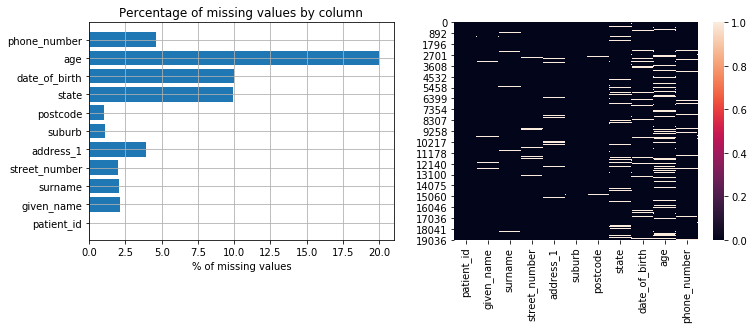

In [8]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.grid()
n_missing_values = df[df.columns[:-1]].isna().sum() / len(df) * 100
plt.barh(n_missing_values.index, n_missing_values)
plt.title('Percentage of missing values by column')
plt.xlabel('% of missing values')

plt.subplot(122)
sns.heatmap(df[df.columns[:-1]].isna())
plt.show()

Pas de valeurs manquantes pour les résultats :

In [9]:
df_pcr.isna().sum()

patient_id    0
pcr           0
dtype: int64

Mais des doublons. Il peut s'agir d'erreurs de frappes/logiciel (exposé dans l'autre notebook) ou de tests à des moments différents. Je les laisse sans changements.

In [10]:
print("Nombre de doublons de patient_id dans les résultats pcr :", len(df_pcr) - len(df_pcr.patient_id.drop_duplicates()))

Nombre de doublons de patient_id dans les résultats pcr : 35


#### <p id='ndd'> Nettoyage des données </p>

Il y a 8 états en Australie

In [11]:
states = list(df.state.value_counts().nlargest(8).index)
df.loc[:, 'state'] = list(map(lambda x: dd.correct_state(x, states), df.loc[:, 'state'])) # dd = detect_duplicate.py (import)

C:\Users\ericw\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### Il y a peu de personnes entre 14 et 17 ans (inclu) qui sont recensées dans ce dataset. Ceux qui ont environ 30 ans sont plus enclins à se faire dépister. On remarque aussi que des enfants de moins de 6 ans sont testés (0 an aussi). 

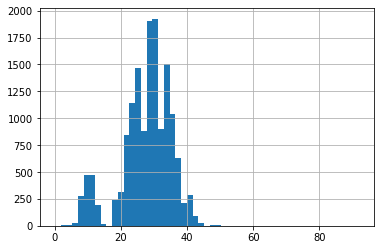

In [12]:
df.age.hist(bins=df.age.nunique()-1)

Il y a une 'forte volonté' chez les 20-40 ans d'aller se faire dépister, suivis par les jeunes (non adultes). Les personnes ayant plus de 40 ans n'iraient pas se faire dépister ? Le manque de données vient peut-être de la manière (et/ou l'endroit) dont est collectée l'information. Si elle vient des hôpitaux, ou de stands nomades, s'il y a besoin d'un rendez-vous. On peut imaginer des scénarios où un segment de la population irait plus se faire tester qu'une autre.

Le nombre exact de personnes par âge :

In [13]:
print('age #personnes')
for age in np.sort(df.age.unique())[:-1]:
    print(age, len(df[df.age == age]))

age #personnes
0.0 1
1.0 1
2.0 4
3.0 4
4.0 6
5.0 4
6.0 28
7.0 112
8.0 164
9.0 232
10.0 238
11.0 238
12.0 237
13.0 191
14.0 12
15.0 3
16.0 1
17.0 1
19.0 244
20.0 314
21.0 364
22.0 482
23.0 526
24.0 619
25.0 685
26.0 783
27.0 878
28.0 948
29.0 954
30.0 968
31.0 957
32.0 902
33.0 844
34.0 657
35.0 552
36.0 489
37.0 366
38.0 266
39.0 216
40.0 169
41.0 116
42.0 54
43.0 33
44.0 16
45.0 13
46.0 2
47.0 2
48.0 1
49.0 3
50.0 1
62.0 1
74.0 1
83.0 1
92.0 1


Déduire l'âge à partir de la date de naissance en prenant l'année 2020 comme année de référence.

In [14]:
birth_not_age = (df.age.isna()) & (~df.date_of_birth.isna())
df.loc[birth_not_age, 'age'] = 2020 - df.loc[birth_not_age, 'date_of_birth'] // 10000

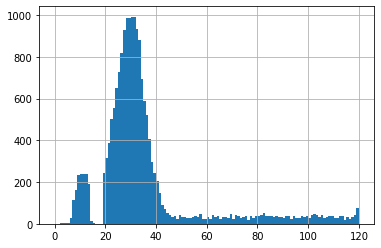

In [15]:
df.age.hist(bins=120)

In [16]:
age = 118
print('Il y a {} personnes de plus de {} ans.'.format(len(df[df.age > age]), age))

Il y a 77 personnes de plus de 118 ans.


Il y aurait des personnes de 120 ans. Oui il y en aurait si on en croit des records du monde, non il n'y en a pas autant en Australie. En ayant seulement la date de naissance, c'est le mieux qu'on puisse faire. Je ne les considère pas comme du bruit, il y a des erreurs de frappes sur l'année de naissance mais peut-être pas sur l'état (le lieu).

Le traitement des NAs: aucun. On souhaite des données fiables plutôt que des données artificielles. Le dataset est déjà assez bruité par les typos lors de la saisie. <br/> On peut deviner l'état à partir du postcode ou du suburb mais ces 2 informations sont parfois contradictoires ou fausses.

### <p id='res'> Les tests pcr </p>

In [17]:
merged_df = df.merge(df_pcr.drop_duplicates(subset='patient_id'), left_on='patient_id', right_on='patient_id')

# Bucket 'age' column
merged_df.age = pd.cut(merged_df.age, [0, 18, 25, 30, 35, 40, 60, 80, max(merged_df.age)])

#### Résultat global des tests 

Nombre de gens testés : 8302


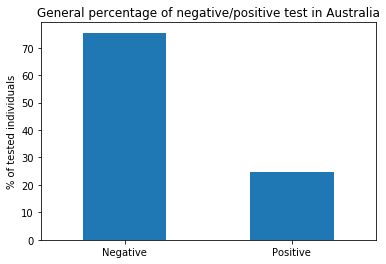

In [18]:
print('Nombre de gens testés :', len(merged_df))
(merged_df.pcr.value_counts()/len(merged_df)*100).plot(kind='bar', rot=0)
plt.title("General percentage of negative/positive test in Australia")
plt.ylabel("% of tested individuals")
plt.show()

On trouve une proportion de 75% négatifs / 25% positifs

#### Résultat par tranche d'âge

Remarque : l'âge n'est pas forcément correct

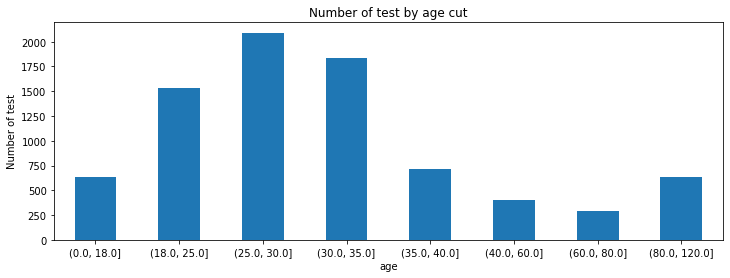

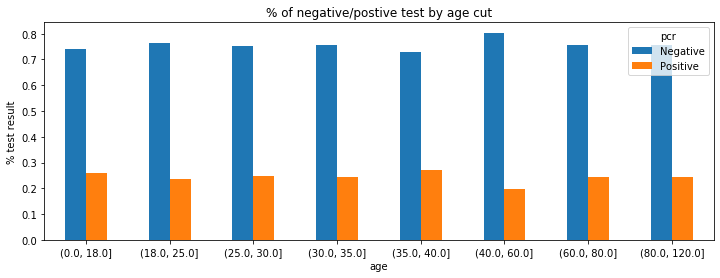

In [19]:
merged_df.groupby('age')['patient_id'].count().plot(kind='bar', rot=0, figsize=(12,4))
plt.title("Number of test by age cut")
plt.ylabel("Number of test")


test_by_age = merged_df.groupby("age").pcr.value_counts().unstack()
test_by_age = test_by_age.divide(test_by_age.sum(axis=1), axis=0)
test_by_age.plot(kind='bar', rot=0, figsize=(12,4))
plt.title("% of negative/postive test by age cut")
plt.ylabel("% test result")
plt.show()

Lâge ne joue pas de rôle majeur sur le fait d'avoir attraper le virus (d'après ce dataset). <br/>On retrouve les proportions du résultat national (75/25).

#### Résultat par état

Remarque : il peut y avoir des habitants de l'état de 'wa' qui se retrouvent dans l'état de 'sa' et inversement au vu de la correction apportée.

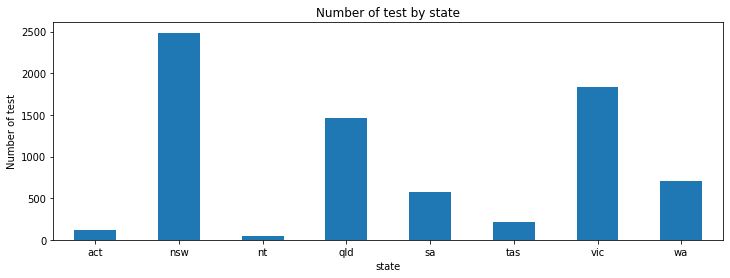

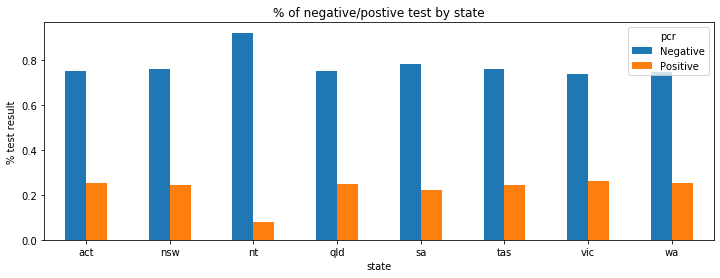

In [20]:
merged_df.groupby('state')['patient_id'].count().plot(kind='bar', rot=0, figsize=(12,4))
plt.title("Number of test by state")
plt.ylabel("Number of test")
plt.show()

test_by_state = merged_df.groupby("state").pcr.value_counts().unstack()
test_by_state = test_by_state.divide(test_by_state.sum(axis=1), axis=0)
test_by_state.plot(kind='bar', rot=0, figsize=(12,4))
plt.title("% of negative/postive test by state")
plt.ylabel("% test result")
plt.show()

Le nombre de test varie grandement selon les états.

Le virus a eu le même impact sur tous les états d'Australie. La différence du 3e bloc dans l'état de NT, vient probablement du fait qu'il y a très peu de tests comparé aux autres états. La proportion de positivité au test n'est pas fiable puisqu'elle peut varier très rapidement lorsque plus de tests sont effectués. Les habitants de NT ne sont pas moins affectés. <br/>On retrouve les proportions du résultat national (75/25).

#### Résidence secondaire

In [21]:
merged_df['second_house'] = merged_df.address_2.isna()

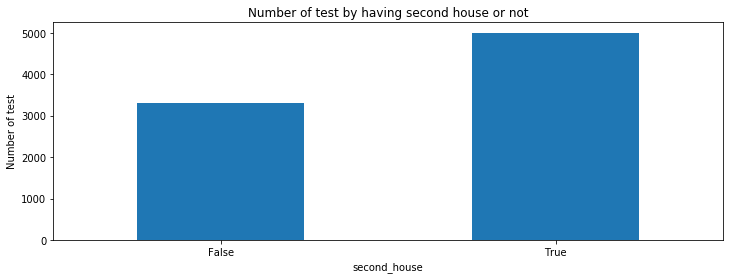

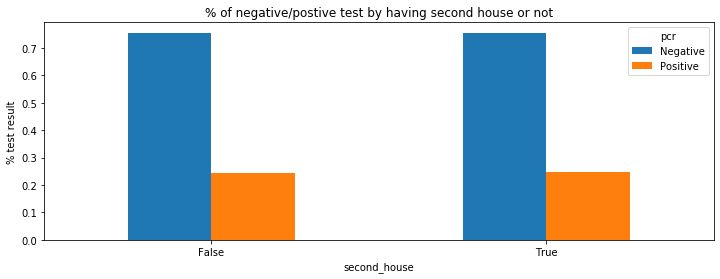

In [22]:
merged_df.groupby('second_house')['patient_id'].count().plot(kind='bar', rot=0, figsize=(12,4))
plt.title("Number of test by having second house or not")
plt.ylabel("Number of test")
plt.show()

test_by_state = merged_df.groupby("second_house").pcr.value_counts().unstack()
test_by_state = test_by_state.divide(test_by_state.sum(axis=1), axis=0)
test_by_state.plot(kind='bar', rot=0, figsize=(12,4))
plt.title("% of negative/postive test by having second house or not")
plt.ylabel("% test result")
plt.show()

Ceux qui ont une 2e résidence font plus de tests que ceux qui n'en ont pas. Les Australiens sont logiques puisqu'en se déplaçant, il y a plus de risque d'être contaminé. On ne voit cependant pas cette différence dans les résultats. <br/>On retrouve les proportions du résultat national (75/25).

Bien entendu, toutes les analyses précédentes sont limitées par le dataset.